# Notebook CNN architecture

A.A. 2022-2023 - HUMAN DATA ANALYTICS

Authors:
* Mattia Brocco
* Brenda Eloisa Tellez Juarez

In [1]:
from google.colab import drive
drive.mount("/content/drive")

#%cd /content/drive/MyDrive/Environmental-sounds-UNIPD-2022

Mounted at /content/drive
/content/drive/MyDrive/Environmental-sounds-UNIPD-2022


In [2]:
import os
import sys
import torch
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from scipy.io import wavfile
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import evaluation
import CNN_support as cnns
from gng import GrowingNeuralGas

%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('./data/meta/esc50.csv')
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Architectural design
First of all data is imported (due to storage requirements the data has already been stored with the train-validation-test split). The latter split is performed via `sklearn.model_selection.train_test_split` with 80% of data used for training, 10% for validation and 10% for test purposes. The method is implemented with `random_state = 42` (common to all architectures in order to provide to all the algorithms the same exact examples).

In [4]:
BATCH_SIZE1 = 100

In [5]:
X_train = pd.read_parquet(".//data/X_train_CNN_60x431x3_7times.parquet")
X_valid = pd.read_parquet(".//data/X_valid_CNN_60x431x3_7times.parquet")
X_test = pd.read_parquet(".//data/X_test_CNN_60x431x3_7times.parquet")
y = pd.read_parquet(".//data/y_CNN_7times.parquet")
y["0"] = y["0"].astype(int)

X_train = X_train.values.reshape(len(X_train), 60, 431, 3)
X_valid = X_valid.values.reshape(len(X_valid), 60, 431, 3)
X_test = X_test.values.reshape(len(X_test), 60, 431, 3)

y_train = y.values[:len(X_train)]
y_valid = y.values[len(X_train):len(X_train) + len(X_valid)]
y_test = y.values[len(X_train) + len(X_valid):]

In [6]:
# Identify and select the TPU
try:
    TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])

    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
except:
    print("TPU not found")

In [7]:
with tpu_strategy.scope():
    # creating the model in the TPUStrategy
    # scope means we will train the model on the TPU
    model0 =  keras.models.Sequential([keras.layers.Conv2D(filters = 30, kernel_size = [12, 6],
                                                           padding = "same", activation = "relu",
                                                           input_shape = [60, 431, 3]),
                                       keras.layers.MaxPool2D(pool_size = (3, 3), strides = (1, 3)),
                                       keras.layers.Dropout(rate = .5),
                                       keras.layers.Conv2D(filters = 30, kernel_size = (1, 3),
                                                           padding = "same", activation = "relu"),
                                       keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)),
                                       keras.layers.Conv2D(filters = 10, kernel_size = (1, 3),
                                                           padding = "same", activation = "relu"),
                                       keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)),
                                       keras.layers.Flatten(),
                                       keras.layers.Dense(500, activation = "relu"),
                                       keras.layers.Dropout(rate = .5),
                                       keras.layers.Dense(50, activation = "softmax") ],
                                      name = "M0")

    model0.compile(loss = "sparse_categorical_crossentropy",
                   metrics = ["accuracy"],
                   optimizer = keras.optimizers.Adam(learning_rate = 1e-4))

print(model0.summary())

Model: "M0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 431, 30)       6510      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 143, 30)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 58, 143, 30)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 143, 30)       2730      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 47, 30)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 47, 10)        910      

In the following cell the training of the CNN is provided. This is done by splitting the training set in 4 separate datasets with the same size (2800 examples).

In [8]:
split_train = []
for j in tqdm(range(4)):
    j_start = int(j*(len(X_train)/4))
    j_stop = int((j+1)*(len(X_train)/4))
    hist_j = model0.fit(X_train[j_start:j_stop], y_train[j_start:j_stop],
                        epochs = 200, batch_size = BATCH_SIZE1,
                        validation_data = (X_valid, y_valid),
                        verbose = 0,
                        callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                   patience = 20)])
  
  split_train.append(hist_j.history)

100%|██████████| 4/4 [13:47<00:00, 206.96s/it]



44/44 - 10s - loss: 0.5960 - accuracy: 0.8450 - 10s/epoch - 228ms/step
Accuracy on test: 84.50%
Memory used: 664.3 Mb


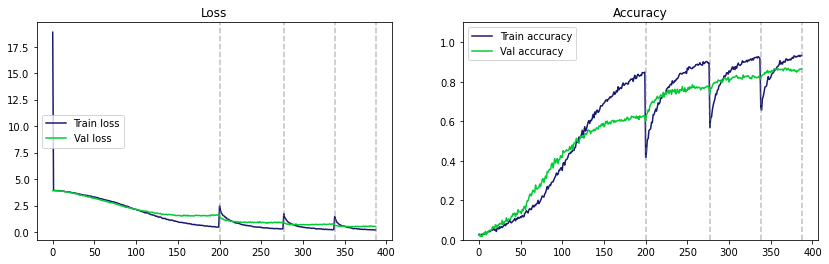

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(split_train[0]["loss"]+split_train[1]["loss"]+
           split_train[2]["loss"]+split_train[3]["loss"],
           label = "Train loss", color = "#191970")
ax[0].plot(split_train[0]["val_loss"]+split_train[1]["val_loss"]+
           split_train[2]["val_loss"]+split_train[3]["val_loss"],
           label = "Val loss", color = "#00CC33")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(split_train[0]["accuracy"]+split_train[1]["accuracy"]+
           split_train[2]["accuracy"]+split_train[3]["accuracy"],
           label = "Train accuracy", color = "#191970")
ax[1].plot(split_train[0]["val_accuracy"]+split_train[1]["val_accuracy"]+
           split_train[2]["val_accuracy"]+split_train[3]["val_accuracy"],
           label = "Val accuracy", color = "#00CC33")
ax[1].set_title("Accuracy")
ax[1].set_ylim(0, 1.1)
ax[1].legend()

for i in range(len(ax)):
    step_n = 0
    for el in split_train:
        step_n += len(el["val_loss"])
        ax[i].axvline(step_n, ls = "--", color = "grey", alpha = .5)

print()
scores0 = model0.evaluate(X_test, y_test, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores0[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model0,
                                                     batch_size = BATCH_SIZE1)/1e6))

plt.show()
#plt.savefig("CNN-only.jpg", dpi = 300)

In [11]:
print(classification_report(y_test, model0.predict(X_test).argmax(axis = 1)))

44/44 [==============================] - 11s 224ms/step
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        35
           1       0.90      1.00      0.95        35
           2       0.92      0.70      0.79        33
           3       0.91      0.94      0.93        34
           4       0.90      0.97      0.93        29
           5       0.86      0.83      0.85        30
           6       0.88      0.68      0.77        34
           7       0.91      0.80      0.85        25
           8       0.93      0.93      0.93        28
           9       0.95      0.91      0.93        22
          10       0.69      0.92      0.79        24
          11       0.81      0.88      0.85        25
          12       0.88      0.97      0.92        30
          13       0.73      0.84      0.78        19
          14       0.96      0.77      0.86        31
          15       0.96      0.72      0.83        36
          16       0.84  

### Input with only two channels
To assess the impact of the addition of the third channel to the input (chromagram), the same architecture presented before is trained with only the first two channels (MFCC and their derivatives).

In [12]:
X_train2 = X_train[:, :, :, :-1]
X_valid2 = X_valid[:, :, :, :-1]
X_test2 = X_test[:, :, :, :-1]

In [13]:
with tpu_strategy.scope():
    # creating the model in the TPUStrategy
    # scope means we will train the model on the TPU
    model2 =  keras.models.Sequential([keras.layers.Conv2D(filters = 30, kernel_size = [12, 6],
                                                           padding = "same", activation = "relu",
                                                           input_shape = [60, 431, 2]),
                                       keras.layers.MaxPool2D(pool_size = (3, 3), strides = (1, 3)),
                                       keras.layers.Dropout(rate = .5),
                                       keras.layers.Conv2D(filters = 30, kernel_size = (1, 3),
                                                           padding = "same", activation = "relu"),
                                       keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)),
                                       keras.layers.Conv2D(filters = 10, kernel_size = (1, 3),
                                                           padding = "same", activation = "relu"),
                                       keras.layers.MaxPool2D(pool_size = (1, 3), strides = (1, 3)),
                                       keras.layers.Flatten(),
                                       keras.layers.Dense(500, activation = "relu"), # BOOSTS PERFORMANCE
                                       keras.layers.Dropout(rate = .5),
                                       keras.layers.Dense(50, activation = "softmax") ],
                                      name = "M2")

    model2.compile(loss = "sparse_categorical_crossentropy",
                   metrics = ["accuracy"],
                   optimizer = keras.optimizers.Adam(learning_rate = 1e-4))

print(model2.summary())

Model: "M2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 431, 30)       4350      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 143, 30)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 58, 143, 30)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 143, 30)       2730      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 58, 47, 30)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 47, 10)        910      

In [14]:
split_train2 = []
for j in tqdm(range(4)):
    j_start = int(j*(len(X_train2)/4))
    j_stop = int((j+1)*(len(X_train2)/4))
    hist_j2 = model2.fit(X_train2[j_start:j_stop], y_train[j_start:j_stop],
                         epochs = 200, batch_size = BATCH_SIZE1,
                         validation_data = (X_valid2, y_valid),
                         verbose = 0,
                         callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                    patience = 20)])
  
    split_train2.append(hist_j2.history)

100%|██████████| 4/4 [17:52<00:00, 268.08s/it]



44/44 - 10s - loss: 1.3673 - accuracy: 0.6514 - 10s/epoch - 235ms/step
Accuracy on test: 65.14%
Memory used: 664.3 Mb


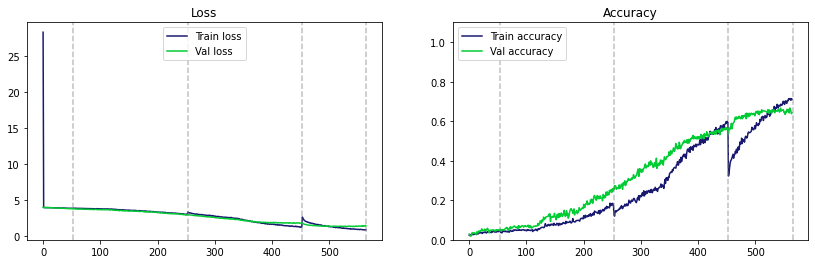

In [15]:
fig2, ax2 = plt.subplots(1, 2, figsize = (14, 4))
ax2[0].plot(split_train2[0]["loss"]+split_train2[1]["loss"]+
            split_train2[2]["loss"]+split_train2[3]["loss"],
            label = "Train loss", color = "#191970")
ax2[0].plot(split_train2[0]["val_loss"]+split_train2[1]["val_loss"]+
            split_train2[2]["val_loss"]+split_train2[3]["val_loss"],
            label = "Val loss", color = "#00CC33")
ax2[0].set_title("Loss")
ax2[0].legend()

ax2[1].plot(split_train2[0]["accuracy"]+split_train2[1]["accuracy"]+
            split_train2[2]["accuracy"]+split_train2[3]["accuracy"],
            label = "Train accuracy", color = "#191970")
ax2[1].plot(split_train2[0]["val_accuracy"]+split_train2[1]["val_accuracy"]+
            split_train2[2]["val_accuracy"]+split_train2[3]["val_accuracy"],
            label = "Val accuracy", color = "#00CC33")
ax2[1].set_title("Accuracy")
ax2[1].set_ylim(0, 1.1)
ax2[1].legend()

for i in range(len(ax2)):
    step_n = 0
    for el in split_train2:
        step_n += len(el["val_loss"])
        ax2[i].axvline(step_n, ls = "--", color = "grey", alpha = .5)

print()
scores2 = model2.evaluate(X_test2, y_test, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores2[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model2,
                                                     batch_size = BATCH_SIZE1)/1e6))

plt.show()
#plt.savefig("CNN-only-2.jpg", dpi = 300)

---
---
---